<a href="https://colab.research.google.com/github/GitMarco27/TMML/blob/main/Notebooks/011_Dtw_Loss_Function.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3 Minutes Machine Learning
## FROM Episode 11: Dtw Loss Function

#### Marco Sanguineti, 2021
---
Welcome to 3 minutes Machine Learning!

Tested on PC win1064-1036593 tf262 (note this is the lower case version!!)
18th August 2023

In [19]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

C:\Users\rbj\AppData\Local\Temp\ipykernel_15448\1158607906.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


In [20]:
print(tf.__version__)
tf.config.list_physical_devices('GPU')

2.6.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Creating DTW Loss Function


---
This works nicely


In [21]:
class DtwLoss(tf.keras.losses.Loss):
    def __init__(self, batch_size: int = 32):
        super(DtwLoss, self).__init__()
        self.batch_size = batch_size

    def call(self, y_true, y_pred):
        tmp = []
        for item in range(self.batch_size):
            #tf.print(f'Working on batch: {item}\n')
            s = y_true[item, :]
            t = y_pred[item, :]
            n, m = len(s), len(t)
            dtw_matrix = []
            for i in range(n + 1):
                line = []
                for j in range(m + 1):
                    if i == 0 and j == 0:
                        line.append(0)
                    else:
                        line.append(np.inf)
                dtw_matrix.append(line)

            for i in range(1, n + 1):
                for j in range(1, m + 1):
                    cost = tf.abs(s[i - 1] - t[j - 1])
                    last_min = tf.reduce_min([dtw_matrix[i - 1][j], dtw_matrix[i][j - 1], dtw_matrix[i - 1][j - 1]])
                    dtw_matrix[i][j] = tf.cast(cost, dtype=tf.float32) + tf.cast(last_min, dtype=tf.float32)

            temp = []
            for i in range(len(dtw_matrix)):
                temp.append(tf.stack(dtw_matrix[i]))

            tmp.append(tf.stack(temp)[n, m])
        return tf.reduce_mean(tmp)

(50, 50)

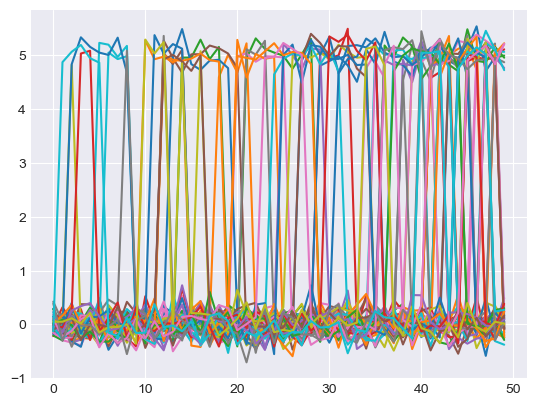

In [40]:
import random
n=50
batch_size=50
noise_amplitude = 0.2  # Adjust the amplitude of the noise

xs=[]
ys=[]
for i in range(batch_size):
    #Draw a straight line
    line = [0 for val in range(n)]
    opens = [5 for val in range(n)]
    # hHw many events?
    events = random.randint(0,5)
    lengths = np.random.randint(1,high=10,size=events)
    miin=0
    
    for event in range(events):
        if miin+lengths[event] < n:
            start = random.randint(miin,n-lengths[event])
            fin = start + lengths[event]
            miin = fin
            line[start:fin] = opens[start:fin]

    # Add noise to the sine wave            
    random_noise = np.random.normal(0, noise_amplitude, n)   

    xs.append(line + random_noise)
    ys.append(line)
    plt.plot(xs[i])
    
np.asarray(xs).shape


Create a couple of curves as actual tensors

In [41]:
#x = tf.Variable(np.cos(np.linspace(0, n)*3.14/180).reshape(1, -1))
#have made a load of them now
x = tf.Variable(np.asarray(xs).reshape(batch_size,-1))
y = tf.Variable(np.asarray(ys).reshape(batch_size,-1))

For a look-see, convery back to numpy and plot'em

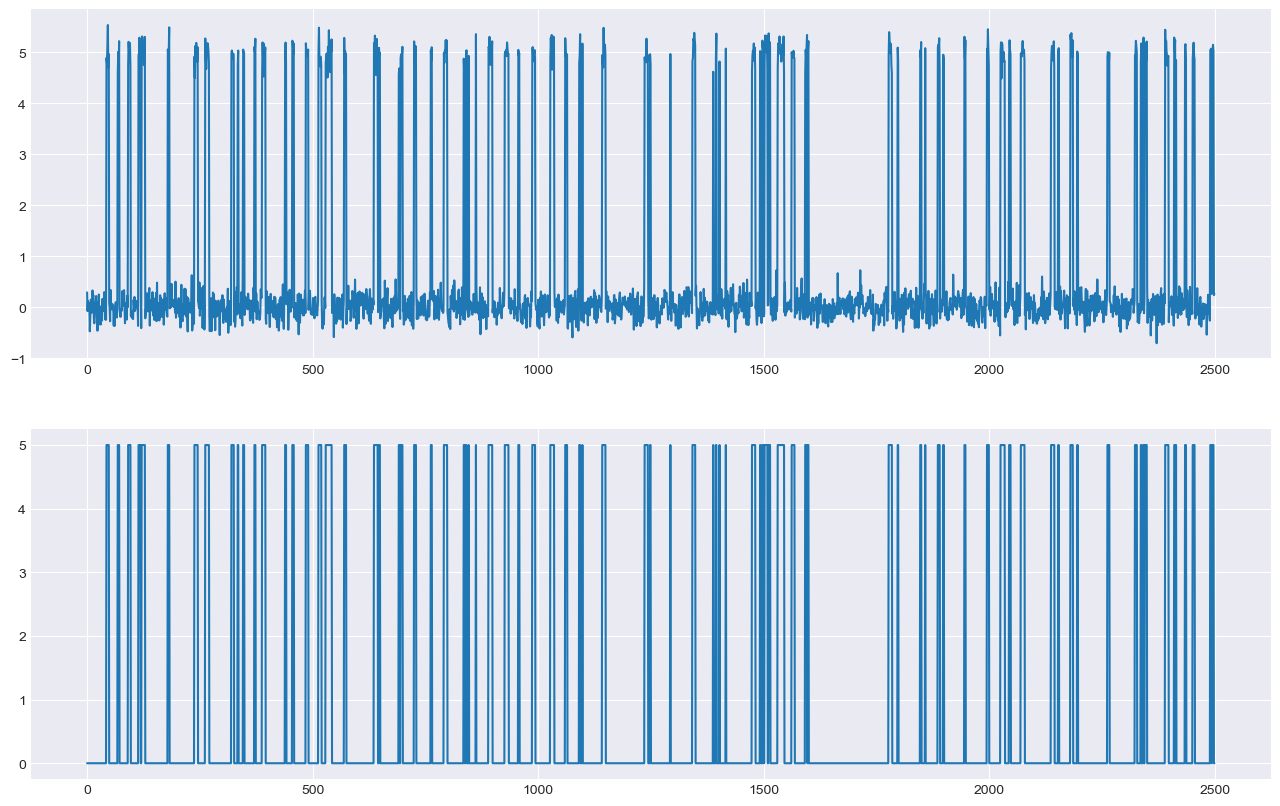

In [42]:
fig, axs = plt.subplots(nrows=2, figsize=(16, 10))
#just plot the first x!
axs[0].plot(x.numpy().reshape(-1))
axs[1].plot(y.numpy().reshape(-1))
plt.show()

Create the loss class
and just see if it works by calling with x as the data and y as the prediction

In [312]:
loss = DtwLoss(batch_size=1)
myloss=loss(x[0,:],x[0,:])
print("Loss value:",myloss)

InvalidArgumentError: Index out of range using input dim 1; input has only 1 dims [Op:StridedSlice] name: DtwLoss/strided_slice/

So it works and returns a suitable value; of course converted to a regular variable to print.

## Basic Stacked Autoencoder Implementation


---
A simple (encoder) NN model with just one layer and 10 fully connected neurones

In [344]:
# Encoder
input = tf.keras.layers.Input(shape=(x.shape[1]))
dense_1 = tf.keras.layers.Dense(10, activation='relu')(input)
encoder = tf.keras.models.Model(inputs=input, outputs=dense_1)
encoder.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                510       
Total params: 510
Trainable params: 510
Non-trainable params: 0
_________________________________________________________________


...and a matching decoder....

In [345]:
# Decoder
input = tf.keras.layers.Input(shape=(10))
dense_1 = tf.keras.layers.Dense(x.shape[1], activation='linear')(input)
decoder = tf.keras.models.Model(inputs=input, outputs=dense_1)
decoder.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense_7 (Dense)              (None, 50)                550       
Total params: 550
Trainable params: 550
Non-trainable params: 0
_________________________________________________________________


In [346]:
# AE
model = tf.keras.models.Sequential([
                                    encoder,
                                    decoder
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_6 (Functional)         (None, 10)                510       
_________________________________________________________________
model_7 (Functional)         (None, 50)                550       
Total params: 1,060
Trainable params: 1,060
Non-trainable params: 0
_________________________________________________________________


In [347]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mean_squared_error')

In [53]:
history = model.fit(x.numpy(), y.numpy(), epochs=10000)

Epoch 1/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4804
Epoch 2/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4809
Epoch 3/10000
2/2 [==============================] - 0s 20ms/step - loss: 0.4818
Epoch 4/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4820
Epoch 5/10000
2/2 [==============================] - 0s 15ms/step - loss: 0.4809
Epoch 6/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4818
Epoch 7/10000
2/2 [==============================] - 0s 12ms/step - loss: 0.4821
Epoch 8/10000
2/2 [==============================] - 0s 10ms/step - loss: 0.4816
Epoch 9/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4830
Epoch 10/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4824
Epoch 11/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4824
Epoch 12/10000
2/2 [==============================] - 0s 8ms/step - loss: 0.4822
Epoch 13/10000
2/2 [=============

2/2 [==============================] - 0s 6ms/step - loss: 0.4818
Epoch 103/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4839
Epoch 104/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4823
Epoch 105/10000
2/2 [==============================] - 0s 10ms/step - loss: 0.4824
Epoch 106/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4849
Epoch 107/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4843
Epoch 108/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4823
Epoch 109/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4803
Epoch 110/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4821
Epoch 111/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4818
Epoch 112/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4811
Epoch 113/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4814
Epoch 114/10000
2/2 [==========

2/2 [==============================] - 0s 5ms/step - loss: 0.4821
Epoch 203/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4810
Epoch 204/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4827
Epoch 205/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4835
Epoch 206/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4830
Epoch 207/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4818
Epoch 208/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4861
Epoch 209/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4868
Epoch 210/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4832
Epoch 211/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4884
Epoch 212/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4987
Epoch 213/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4954
Epoch 214/10000
2/2 [===========

2/2 [==============================] - 0s 6ms/step - loss: 0.4817
Epoch 303/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4806
Epoch 304/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4817
Epoch 305/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4821
Epoch 306/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4808
Epoch 307/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4819
Epoch 308/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4819
Epoch 309/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4816
Epoch 310/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4823
Epoch 311/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4808
Epoch 312/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4816
Epoch 313/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4800
Epoch 314/10000
2/2 [===========

2/2 [==============================] - 0s 5ms/step - loss: 0.4821
Epoch 403/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4870
Epoch 404/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4861
Epoch 405/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4838
Epoch 406/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4842
Epoch 407/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4854
Epoch 408/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4858
Epoch 409/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4833
Epoch 410/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4819
Epoch 411/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4859
Epoch 412/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4837
Epoch 413/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4813
Epoch 414/10000
2/2 [===========

2/2 [==============================] - 0s 4ms/step - loss: 0.4847
Epoch 503/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4831
Epoch 504/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4870
Epoch 505/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4856
Epoch 506/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4869
Epoch 507/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4855
Epoch 508/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4854
Epoch 509/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4856
Epoch 510/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4836
Epoch 511/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4816
Epoch 512/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4849
Epoch 513/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4826
Epoch 514/10000
2/2 [===========

2/2 [==============================] - 0s 4ms/step - loss: 0.4798
Epoch 603/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4826
Epoch 604/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4819
Epoch 605/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4804
Epoch 606/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4811
Epoch 607/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4821
Epoch 608/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4823
Epoch 609/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4818
Epoch 610/10000
2/2 [==============================] - 0s 15ms/step - loss: 0.4807
Epoch 611/10000
2/2 [==============================] - 0s 8ms/step - loss: 0.4804
Epoch 612/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4804
Epoch 613/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4813
Epoch 614/10000
2/2 [==========

2/2 [==============================] - 0s 5ms/step - loss: 0.4802
Epoch 703/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4821
Epoch 704/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4813
Epoch 705/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4820
Epoch 706/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4809
Epoch 707/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4805
Epoch 708/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4812
Epoch 709/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4804
Epoch 710/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4818
Epoch 711/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4808
Epoch 712/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4814
Epoch 713/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4793
Epoch 714/10000
2/2 [===========

2/2 [==============================] - 0s 4ms/step - loss: 0.4932
Epoch 803/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4929
Epoch 804/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4911
Epoch 805/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4942
Epoch 806/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4886
Epoch 807/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4986
Epoch 808/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4941
Epoch 809/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4882
Epoch 810/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4903
Epoch 811/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4888
Epoch 812/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4869
Epoch 813/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4929
Epoch 814/10000
2/2 [===========

2/2 [==============================] - 0s 5ms/step - loss: 0.4791
Epoch 903/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4807
Epoch 904/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4803
Epoch 905/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4805
Epoch 906/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4797
Epoch 907/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4783
Epoch 908/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4806
Epoch 909/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4798
Epoch 910/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4806
Epoch 911/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4795
Epoch 912/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4800
Epoch 913/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4794
Epoch 914/10000
2/2 [===========

2/2 [==============================] - 0s 4ms/step - loss: 0.4811
Epoch 1003/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4819
Epoch 1004/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4805
Epoch 1005/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4808
Epoch 1006/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4816
Epoch 1007/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4810
Epoch 1008/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4811
Epoch 1009/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4813
Epoch 1010/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4817
Epoch 1011/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4812
Epoch 1012/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4801
Epoch 1013/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4806
Epoch 1014/10000
2/2 

2/2 [==============================] - 0s 4ms/step - loss: 0.4818
Epoch 1101/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4811
Epoch 1102/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4802
Epoch 1103/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4807
Epoch 1104/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4821
Epoch 1105/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4813
Epoch 1106/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4814
Epoch 1107/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4806
Epoch 1108/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4811
Epoch 1109/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4806
Epoch 1110/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4807
Epoch 1111/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4804
Epoch 1112/10000
2/2 

2/2 [==============================] - 0s 4ms/step - loss: 0.4930
Epoch 1199/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4851
Epoch 1200/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4941
Epoch 1201/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.5024
Epoch 1202/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4947
Epoch 1203/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4889
Epoch 1204/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.5006
Epoch 1205/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4908
Epoch 1206/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4901
Epoch 1207/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4882
Epoch 1208/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4906
Epoch 1209/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4870
Epoch 1210/10000
2/2 

2/2 [==============================] - 0s 4ms/step - loss: 0.4814
Epoch 1297/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4820
Epoch 1298/10000
2/2 [==============================] - 0s 17ms/step - loss: 0.4828
Epoch 1299/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4808
Epoch 1300/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4819
Epoch 1301/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4817
Epoch 1302/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4809
Epoch 1303/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4795
Epoch 1304/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4803
Epoch 1305/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4804
Epoch 1306/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4791
Epoch 1307/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4805
Epoch 1308/10000
2/2

2/2 [==============================] - 0s 5ms/step - loss: 0.4797
Epoch 1395/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4810
Epoch 1396/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4813
Epoch 1397/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4829
Epoch 1398/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4822
Epoch 1399/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4803
Epoch 1400/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4812
Epoch 1401/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4817
Epoch 1402/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4824
Epoch 1403/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4820
Epoch 1404/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4810
Epoch 1405/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4832
Epoch 1406/10000
2/2 

2/2 [==============================] - 0s 4ms/step - loss: 0.5020
Epoch 1493/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4936
Epoch 1494/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4905
Epoch 1495/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4920
Epoch 1496/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4877
Epoch 1497/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4900
Epoch 1498/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4873
Epoch 1499/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4973
Epoch 1500/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4907
Epoch 1501/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4919
Epoch 1502/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4912
Epoch 1503/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4974
Epoch 1504/10000
2/2 

2/2 [==============================] - 0s 6ms/step - loss: 0.4801
Epoch 1591/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4795
Epoch 1592/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4823
Epoch 1593/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4803
Epoch 1594/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4809
Epoch 1595/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4792
Epoch 1596/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4786
Epoch 1597/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4803
Epoch 1598/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4811
Epoch 1599/10000
2/2 [==============================] - 0s 9ms/step - loss: 0.4814
Epoch 1600/10000
2/2 [==============================] - 0s 8ms/step - loss: 0.4807
Epoch 1601/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4793
Epoch 1602/10000
2/2 

2/2 [==============================] - 0s 8ms/step - loss: 0.4823
Epoch 1689/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4806
Epoch 1690/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4809
Epoch 1691/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4830
Epoch 1692/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4818
Epoch 1693/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4808
Epoch 1694/10000
2/2 [==============================] - 0s 3ms/step - loss: 0.4796
Epoch 1695/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4798
Epoch 1696/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4804
Epoch 1697/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4813
Epoch 1698/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4811
Epoch 1699/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4809
Epoch 1700/10000
2/2 

2/2 [==============================] - 0s 5ms/step - loss: 0.4792
Epoch 1787/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4780
Epoch 1788/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4794
Epoch 1789/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4814
Epoch 1790/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4803
Epoch 1791/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4787
Epoch 1792/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4797
Epoch 1793/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4829
Epoch 1794/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4816
Epoch 1795/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4828
Epoch 1796/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4814
Epoch 1797/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4822
Epoch 1798/10000
2/2 

2/2 [==============================] - 0s 5ms/step - loss: 0.4816
Epoch 1885/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4821
Epoch 1886/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4811
Epoch 1887/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4807
Epoch 1888/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4818
Epoch 1889/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4825
Epoch 1890/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4810
Epoch 1891/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4822
Epoch 1892/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4815
Epoch 1893/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4820
Epoch 1894/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4822
Epoch 1895/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4811
Epoch 1896/10000
2/2 

2/2 [==============================] - 0s 7ms/step - loss: 0.4826
Epoch 1983/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4808
Epoch 1984/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4805
Epoch 1985/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4820
Epoch 1986/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4802
Epoch 1987/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4801
Epoch 1988/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4806
Epoch 1989/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4820
Epoch 1990/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4815
Epoch 1991/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4799
Epoch 1992/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4811
Epoch 1993/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4805
Epoch 1994/10000
2/2 

2/2 [==============================] - 0s 6ms/step - loss: 0.4825
Epoch 2081/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4809
Epoch 2082/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4859
Epoch 2083/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4882
Epoch 2084/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4889
Epoch 2085/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4849
Epoch 2086/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4899
Epoch 2087/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4902
Epoch 2088/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4907
Epoch 2089/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4833
Epoch 2090/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.5024
Epoch 2091/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4901
Epoch 2092/10000
2/2 

2/2 [==============================] - 0s 5ms/step - loss: 0.4826
Epoch 2179/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4823
Epoch 2180/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4822
Epoch 2181/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4816
Epoch 2182/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4808
Epoch 2183/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4825
Epoch 2184/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4807
Epoch 2185/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4797
Epoch 2186/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4815
Epoch 2187/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4812
Epoch 2188/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4811
Epoch 2189/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4812
Epoch 2190/10000
2/2 

2/2 [==============================] - 0s 4ms/step - loss: 0.4815
Epoch 2277/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4809
Epoch 2278/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4799
Epoch 2279/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4793
Epoch 2280/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4808
Epoch 2281/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4813
Epoch 2282/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4809
Epoch 2283/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4795
Epoch 2284/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4811
Epoch 2285/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4806
Epoch 2286/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4806
Epoch 2287/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4809
Epoch 2288/10000
2/2 

2/2 [==============================] - 0s 7ms/step - loss: 0.4832
Epoch 2375/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4831
Epoch 2376/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4825
Epoch 2377/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4826
Epoch 2378/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4818
Epoch 2379/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4836
Epoch 2380/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4812
Epoch 2381/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4839
Epoch 2382/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4850
Epoch 2383/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4846
Epoch 2384/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4821
Epoch 2385/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4821
Epoch 2386/10000
2/2 

2/2 [==============================] - 0s 4ms/step - loss: 0.4800
Epoch 2473/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4809
Epoch 2474/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4807
Epoch 2475/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4812
Epoch 2476/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4809
Epoch 2477/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4809
Epoch 2478/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4801
Epoch 2479/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4798
Epoch 2480/10000
2/2 [==============================] - 0s 17ms/step - loss: 0.4799
Epoch 2481/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4792
Epoch 2482/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4794
Epoch 2483/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4820
Epoch 2484/10000
2/2

2/2 [==============================] - 0s 5ms/step - loss: 0.4800
Epoch 2571/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4800
Epoch 2572/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4801
Epoch 2573/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4800
Epoch 2574/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4807
Epoch 2575/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4804
Epoch 2576/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4807
Epoch 2577/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4808
Epoch 2578/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4787
Epoch 2579/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4807
Epoch 2580/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4793
Epoch 2581/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4807
Epoch 2582/10000
2/2 

2/2 [==============================] - 0s 5ms/step - loss: 0.4838
Epoch 2669/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4837
Epoch 2670/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4828
Epoch 2671/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4852
Epoch 2672/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4825
Epoch 2673/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4822
Epoch 2674/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4807
Epoch 2675/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4856
Epoch 2676/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4845
Epoch 2677/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4808
Epoch 2678/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4825
Epoch 2679/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4850
Epoch 2680/10000
2/2 

2/2 [==============================] - 0s 4ms/step - loss: 0.4845
Epoch 2767/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4828
Epoch 2768/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4905
Epoch 2769/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4897
Epoch 2770/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4846
Epoch 2771/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.5049
Epoch 2772/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.5010
Epoch 2773/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4919
Epoch 2774/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4938
Epoch 2775/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.5017
Epoch 2776/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4906
Epoch 2777/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.5027
Epoch 2778/10000
2/2 

2/2 [==============================] - 0s 5ms/step - loss: 0.4802
Epoch 2865/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4793
Epoch 2866/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4805
Epoch 2867/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4791
Epoch 2868/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4800
Epoch 2869/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4805
Epoch 2870/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4808
Epoch 2871/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4797
Epoch 2872/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4812
Epoch 2873/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4810
Epoch 2874/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4796
Epoch 2875/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4806
Epoch 2876/10000
2/2 

2/2 [==============================] - 0s 4ms/step - loss: 0.4809
Epoch 2963/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4813
Epoch 2964/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4807
Epoch 2965/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4805
Epoch 2966/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4808
Epoch 2967/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4807
Epoch 2968/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4819
Epoch 2969/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4804
Epoch 2970/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4819
Epoch 2971/10000
2/2 [==============================] - 0s 3ms/step - loss: 0.4809
Epoch 2972/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4835
Epoch 2973/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4831
Epoch 2974/10000
2/2 

2/2 [==============================] - 0s 6ms/step - loss: 0.4803
Epoch 3061/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4799
Epoch 3062/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4804
Epoch 3063/10000
2/2 [==============================] - 0s 3ms/step - loss: 0.4802
Epoch 3064/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4805
Epoch 3065/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4800
Epoch 3066/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4802
Epoch 3067/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4813
Epoch 3068/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4813
Epoch 3069/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4808
Epoch 3070/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4803
Epoch 3071/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4814
Epoch 3072/10000
2/2 

2/2 [==============================] - 0s 5ms/step - loss: 0.4839
Epoch 3159/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4853
Epoch 3160/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4841
Epoch 3161/10000
2/2 [==============================] - 0s 3ms/step - loss: 0.4829
Epoch 3162/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4886
Epoch 3163/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4847
Epoch 3164/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4847
Epoch 3165/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4862
Epoch 3166/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4834
Epoch 3167/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4837
Epoch 3168/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4829
Epoch 3169/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4830
Epoch 3170/10000
2/2 

2/2 [==============================] - 0s 5ms/step - loss: 0.4799
Epoch 3257/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4792
Epoch 3258/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4801
Epoch 3259/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4802
Epoch 3260/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4806
Epoch 3261/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4800
Epoch 3262/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4796
Epoch 3263/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4801
Epoch 3264/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4802
Epoch 3265/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4792
Epoch 3266/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4795
Epoch 3267/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4793
Epoch 3268/10000
2/2 

2/2 [==============================] - 0s 4ms/step - loss: 0.4835
Epoch 3355/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4863
Epoch 3356/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4874
Epoch 3357/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4872
Epoch 3358/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4861
Epoch 3359/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4848
Epoch 3360/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4862
Epoch 3361/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4848
Epoch 3362/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4864
Epoch 3363/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4835
Epoch 3364/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4840
Epoch 3365/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4842
Epoch 3366/10000
2/2 

2/2 [==============================] - 0s 5ms/step - loss: 0.4793
Epoch 3453/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4794
Epoch 3454/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4803
Epoch 3455/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4786
Epoch 3456/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4805
Epoch 3457/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4819
Epoch 3458/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4801
Epoch 3459/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4787
Epoch 3460/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4809
Epoch 3461/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4810
Epoch 3462/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4800
Epoch 3463/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4802
Epoch 3464/10000
2/2 

2/2 [==============================] - 0s 6ms/step - loss: 0.4791
Epoch 3551/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4804
Epoch 3552/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4814
Epoch 3553/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4806
Epoch 3554/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4795
Epoch 3555/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4805
Epoch 3556/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4812
Epoch 3557/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4807
Epoch 3558/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4804
Epoch 3559/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4814
Epoch 3560/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4803
Epoch 3561/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4803
Epoch 3562/10000
2/2 

2/2 [==============================] - 0s 7ms/step - loss: 0.4818
Epoch 3649/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4806
Epoch 3650/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4807
Epoch 3651/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4815
Epoch 3652/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4816
Epoch 3653/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4805
Epoch 3654/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4832
Epoch 3655/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4809
Epoch 3656/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4808
Epoch 3657/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4824
Epoch 3658/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4823
Epoch 3659/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4809
Epoch 3660/10000
2/2 

2/2 [==============================] - 0s 5ms/step - loss: 0.4790
Epoch 3747/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4807
Epoch 3748/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4807
Epoch 3749/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4811
Epoch 3750/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4826
Epoch 3751/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4812
Epoch 3752/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4803
Epoch 3753/10000
2/2 [==============================] - 0s 3ms/step - loss: 0.4811
Epoch 3754/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4807
Epoch 3755/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4810
Epoch 3756/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4822
Epoch 3757/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4813
Epoch 3758/10000
2/2 

2/2 [==============================] - 0s 6ms/step - loss: 0.4805
Epoch 3845/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4795
Epoch 3846/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4789
Epoch 3847/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4793
Epoch 3848/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4807
Epoch 3849/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4796
Epoch 3850/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4795
Epoch 3851/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4802
Epoch 3852/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4812
Epoch 3853/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4802
Epoch 3854/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4801
Epoch 3855/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4805
Epoch 3856/10000
2/2 

2/2 [==============================] - 0s 4ms/step - loss: 0.4819
Epoch 3943/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4812
Epoch 3944/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4827
Epoch 3945/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4820
Epoch 3946/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4825
Epoch 3947/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4815
Epoch 3948/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4834
Epoch 3949/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4830
Epoch 3950/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4819
Epoch 3951/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4863
Epoch 3952/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4843
Epoch 3953/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4821
Epoch 3954/10000
2/2 

2/2 [==============================] - 0s 4ms/step - loss: 0.4858
Epoch 4041/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4872
Epoch 4042/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4877
Epoch 4043/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4862
Epoch 4044/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4893
Epoch 4045/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4871
Epoch 4046/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4861
Epoch 4047/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4993
Epoch 4048/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4975
Epoch 4049/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4886
Epoch 4050/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4965
Epoch 4051/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4916
Epoch 4052/10000
2/2 

2/2 [==============================] - 0s 5ms/step - loss: 0.4797
Epoch 4139/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4795
Epoch 4140/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4801
Epoch 4141/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4795
Epoch 4142/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4802
Epoch 4143/10000
2/2 [==============================] - 0s 3ms/step - loss: 0.4795
Epoch 4144/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4806
Epoch 4145/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4815
Epoch 4146/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4807
Epoch 4147/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4811
Epoch 4148/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4798
Epoch 4149/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4810
Epoch 4150/10000
2/2 

2/2 [==============================] - 0s 6ms/step - loss: 0.4807
Epoch 4237/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4812
Epoch 4238/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4801
Epoch 4239/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4792
Epoch 4240/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4786
Epoch 4241/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4783
Epoch 4242/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4798
Epoch 4243/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4804
Epoch 4244/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4796
Epoch 4245/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4791
Epoch 4246/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4799
Epoch 4247/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4796
Epoch 4248/10000
2/2 

2/2 [==============================] - 0s 6ms/step - loss: 0.4955
Epoch 4335/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4944
Epoch 4336/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4981
Epoch 4337/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4912
Epoch 4338/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4876
Epoch 4339/10000
2/2 [==============================] - 0s 3ms/step - loss: 0.4920
Epoch 4340/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4860
Epoch 4341/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4883
Epoch 4342/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4858
Epoch 4343/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4851
Epoch 4344/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4846
Epoch 4345/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4833
Epoch 4346/10000
2/2 

2/2 [==============================] - 0s 7ms/step - loss: 0.4813
Epoch 4433/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4790
Epoch 4434/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4787
Epoch 4435/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4786
Epoch 4436/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4803
Epoch 4437/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4810
Epoch 4438/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4794
Epoch 4439/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4790
Epoch 4440/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4799
Epoch 4441/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4794
Epoch 4442/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4801
Epoch 4443/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4788
Epoch 4444/10000
2/2 

2/2 [==============================] - 0s 4ms/step - loss: 0.4807
Epoch 4531/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4797
Epoch 4532/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4789
Epoch 4533/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4790
Epoch 4534/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4794
Epoch 4535/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4804
Epoch 4536/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4805
Epoch 4537/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4806
Epoch 4538/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4797
Epoch 4539/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4796
Epoch 4540/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4789
Epoch 4541/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4794
Epoch 4542/10000
2/2 

2/2 [==============================] - 0s 8ms/step - loss: 0.5018
Epoch 4629/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.5058
Epoch 4630/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.5172
Epoch 4631/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.5068
Epoch 4632/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.5028
Epoch 4633/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.5226
Epoch 4634/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4998
Epoch 4635/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.5004
Epoch 4636/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.5039
Epoch 4637/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4996
Epoch 4638/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4975
Epoch 4639/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4927
Epoch 4640/10000
2/2 

2/2 [==============================] - 0s 4ms/step - loss: 0.4799
Epoch 4727/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4789
Epoch 4728/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4803
Epoch 4729/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4797
Epoch 4730/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4792
Epoch 4731/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4795
Epoch 4732/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4800
Epoch 4733/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4793
Epoch 4734/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4801
Epoch 4735/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4797
Epoch 4736/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4794
Epoch 4737/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4788
Epoch 4738/10000
2/2 

2/2 [==============================] - 0s 4ms/step - loss: 0.4789
Epoch 4825/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4811
Epoch 4826/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4804
Epoch 4827/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4796
Epoch 4828/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4794
Epoch 4829/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4795
Epoch 4830/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4792
Epoch 4831/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4802
Epoch 4832/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4806
Epoch 4833/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4796
Epoch 4834/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4794
Epoch 4835/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4802
Epoch 4836/10000
2/2 

2/2 [==============================] - 0s 4ms/step - loss: 0.4839
Epoch 4923/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4830
Epoch 4924/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4844
Epoch 4925/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4830
Epoch 4926/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4844
Epoch 4927/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4872
Epoch 4928/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4831
Epoch 4929/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4882
Epoch 4930/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4946
Epoch 4931/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4884
Epoch 4932/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4864
Epoch 4933/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4902
Epoch 4934/10000
2/2 

2/2 [==============================] - 0s 8ms/step - loss: 0.4797
Epoch 5021/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4788
Epoch 5022/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4793
Epoch 5023/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4793
Epoch 5024/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4805
Epoch 5025/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4798
Epoch 5026/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4787
Epoch 5027/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4802
Epoch 5028/10000
2/2 [==============================] - 0s 8ms/step - loss: 0.4812
Epoch 5029/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4805
Epoch 5030/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4783
Epoch 5031/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4799
Epoch 5032/10000
2/2 

2/2 [==============================] - 0s 4ms/step - loss: 0.4799
Epoch 5119/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4804
Epoch 5120/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4803
Epoch 5121/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4809
Epoch 5122/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4803
Epoch 5123/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4794
Epoch 5124/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4803
Epoch 5125/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4813
Epoch 5126/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4811
Epoch 5127/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4804
Epoch 5128/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4799
Epoch 5129/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4799
Epoch 5130/10000
2/2 

2/2 [==============================] - 0s 4ms/step - loss: 0.4847
Epoch 5217/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4856
Epoch 5218/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4824
Epoch 5219/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4803
Epoch 5220/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4809
Epoch 5221/10000
2/2 [==============================] - 0s 3ms/step - loss: 0.4818
Epoch 5222/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4826
Epoch 5223/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4819
Epoch 5224/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4820
Epoch 5225/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4817
Epoch 5226/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4825
Epoch 5227/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4814
Epoch 5228/10000
2/2 

2/2 [==============================] - 0s 7ms/step - loss: 0.4806
Epoch 5315/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4801
Epoch 5316/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4797
Epoch 5317/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4819
Epoch 5318/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4823
Epoch 5319/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4814
Epoch 5320/10000
2/2 [==============================] - 0s 3ms/step - loss: 0.4816
Epoch 5321/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4807
Epoch 5322/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4823
Epoch 5323/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4836
Epoch 5324/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4812
Epoch 5325/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4823
Epoch 5326/10000
2/2 

2/2 [==============================] - 0s 6ms/step - loss: 0.4928
Epoch 5413/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4889
Epoch 5414/10000
2/2 [==============================] - 0s 8ms/step - loss: 0.4919
Epoch 5415/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4921
Epoch 5416/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4898
Epoch 5417/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4858
Epoch 5418/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4874
Epoch 5419/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4862
Epoch 5420/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4835
Epoch 5421/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4850
Epoch 5422/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4849
Epoch 5423/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4824
Epoch 5424/10000
2/2 

2/2 [==============================] - 0s 5ms/step - loss: 0.4820
Epoch 5511/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4814
Epoch 5512/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4802
Epoch 5513/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4791
Epoch 5514/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4843
Epoch 5515/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4814
Epoch 5516/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4816
Epoch 5517/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4812
Epoch 5518/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4818
Epoch 5519/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4812
Epoch 5520/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4825
Epoch 5521/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4832
Epoch 5522/10000
2/2 

2/2 [==============================] - 0s 5ms/step - loss: 0.4811
Epoch 5609/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4809
Epoch 5610/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4804
Epoch 5611/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4805
Epoch 5612/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4820
Epoch 5613/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4814
Epoch 5614/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4796
Epoch 5615/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4803
Epoch 5616/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4808
Epoch 5617/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4804
Epoch 5618/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4797
Epoch 5619/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4787
Epoch 5620/10000
2/2 

2/2 [==============================] - 0s 6ms/step - loss: 0.4844
Epoch 5707/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4860
Epoch 5708/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4884
Epoch 5709/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4859
Epoch 5710/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4863
Epoch 5711/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4897
Epoch 5712/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4922
Epoch 5713/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4910
Epoch 5714/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4840
Epoch 5715/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.5010
Epoch 5716/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4993
Epoch 5717/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4917
Epoch 5718/10000
2/2 

2/2 [==============================] - 0s 6ms/step - loss: 0.4810
Epoch 5805/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4790
Epoch 5806/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4801
Epoch 5807/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4819
Epoch 5808/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4811
Epoch 5809/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4802
Epoch 5810/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4810
Epoch 5811/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4813
Epoch 5812/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4795
Epoch 5813/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4805
Epoch 5814/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4814
Epoch 5815/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4807
Epoch 5816/10000
2/2 

2/2 [==============================] - 0s 4ms/step - loss: 0.5143
Epoch 5903/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.5028
Epoch 5904/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.5118
Epoch 5905/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4985
Epoch 5906/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.5040
Epoch 5907/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4940
Epoch 5908/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4958
Epoch 5909/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4893
Epoch 5910/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4896
Epoch 5911/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4878
Epoch 5912/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4897
Epoch 5913/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4885
Epoch 5914/10000
2/2 

2/2 [==============================] - 0s 4ms/step - loss: 0.4802
Epoch 6001/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4798
Epoch 6002/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4812
Epoch 6003/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4800
Epoch 6004/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4801
Epoch 6005/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4793
Epoch 6006/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4797
Epoch 6007/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4791
Epoch 6008/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4786
Epoch 6009/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4798
Epoch 6010/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4801
Epoch 6011/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4803
Epoch 6012/10000
2/2 

2/2 [==============================] - 0s 5ms/step - loss: 0.4798
Epoch 6099/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4800
Epoch 6100/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4800
Epoch 6101/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4804
Epoch 6102/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4801
Epoch 6103/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4795
Epoch 6104/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4794
Epoch 6105/10000
2/2 [==============================] - 0s 3ms/step - loss: 0.4783
Epoch 6106/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4796
Epoch 6107/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4801
Epoch 6108/10000
2/2 [==============================] - 0s 3ms/step - loss: 0.4802
Epoch 6109/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4803
Epoch 6110/10000
2/2 

2/2 [==============================] - 0s 4ms/step - loss: 0.4801
Epoch 6197/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4803
Epoch 6198/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4801
Epoch 6199/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4791
Epoch 6200/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4803
Epoch 6201/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4792
Epoch 6202/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4797
Epoch 6203/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4799
Epoch 6204/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4801
Epoch 6205/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4809
Epoch 6206/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4791
Epoch 6207/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4797
Epoch 6208/10000
2/2 

2/2 [==============================] - 0s 4ms/step - loss: 0.4874
Epoch 6295/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4879
Epoch 6296/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4852
Epoch 6297/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4874
Epoch 6298/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4918
Epoch 6299/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4923
Epoch 6300/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4855
Epoch 6301/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4947
Epoch 6302/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4952
Epoch 6303/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4983
Epoch 6304/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4936
Epoch 6305/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.5079
Epoch 6306/10000
2/2 

2/2 [==============================] - 0s 4ms/step - loss: 0.4804
Epoch 6393/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4809
Epoch 6394/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4797
Epoch 6395/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4807
Epoch 6396/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4805
Epoch 6397/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4808
Epoch 6398/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4803
Epoch 6399/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4818
Epoch 6400/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4818
Epoch 6401/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4799
Epoch 6402/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4820
Epoch 6403/10000
2/2 [==============================] - 0s 8ms/step - loss: 0.4805
Epoch 6404/10000
2/2 

2/2 [==============================] - 0s 6ms/step - loss: 0.4788
Epoch 6491/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4793
Epoch 6492/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4800
Epoch 6493/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4796
Epoch 6494/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4800
Epoch 6495/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4794
Epoch 6496/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4788
Epoch 6497/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4812
Epoch 6498/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4797
Epoch 6499/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4802
Epoch 6500/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4790
Epoch 6501/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4790
Epoch 6502/10000
2/2 

2/2 [==============================] - 0s 5ms/step - loss: 0.4844
Epoch 6589/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4841
Epoch 6590/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4877
Epoch 6591/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4836
Epoch 6592/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4854
Epoch 6593/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4844
Epoch 6594/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4857
Epoch 6595/10000
2/2 [==============================] - 0s 3ms/step - loss: 0.4841
Epoch 6596/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4838
Epoch 6597/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4860
Epoch 6598/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4896
Epoch 6599/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4852
Epoch 6600/10000
2/2 

2/2 [==============================] - 0s 5ms/step - loss: 0.4808
Epoch 6687/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4806
Epoch 6688/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4802
Epoch 6689/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4811
Epoch 6690/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4817
Epoch 6691/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4815
Epoch 6692/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4804
Epoch 6693/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4803
Epoch 6694/10000
2/2 [==============================] - 0s 3ms/step - loss: 0.4802
Epoch 6695/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4797
Epoch 6696/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4795
Epoch 6697/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4806
Epoch 6698/10000
2/2 

2/2 [==============================] - 0s 6ms/step - loss: 0.4806
Epoch 6785/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4792
Epoch 6786/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4788
Epoch 6787/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4803
Epoch 6788/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4806
Epoch 6789/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4805
Epoch 6790/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4799
Epoch 6791/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4807
Epoch 6792/10000
2/2 [==============================] - 0s 3ms/step - loss: 0.4804
Epoch 6793/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4789
Epoch 6794/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4787
Epoch 6795/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4820
Epoch 6796/10000
2/2 

2/2 [==============================] - 0s 4ms/step - loss: 0.4796
Epoch 6883/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4803
Epoch 6884/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4800
Epoch 6885/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4809
Epoch 6886/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4801
Epoch 6887/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4810
Epoch 6888/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4797
Epoch 6889/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4795
Epoch 6890/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4795
Epoch 6891/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4799
Epoch 6892/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4804
Epoch 6893/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4806
Epoch 6894/10000
2/2 

2/2 [==============================] - 0s 5ms/step - loss: 0.4816
Epoch 6981/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4836
Epoch 6982/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4828
Epoch 6983/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4842
Epoch 6984/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4821
Epoch 6985/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4819
Epoch 6986/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4825
Epoch 6987/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4824
Epoch 6988/10000
2/2 [==============================] - 0s 3ms/step - loss: 0.4822
Epoch 6989/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4813
Epoch 6990/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4812
Epoch 6991/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4831
Epoch 6992/10000
2/2 

2/2 [==============================] - 0s 5ms/step - loss: 0.4826
Epoch 7079/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4810
Epoch 7080/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4825
Epoch 7081/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4822
Epoch 7082/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4838
Epoch 7083/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4843
Epoch 7084/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4856
Epoch 7085/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4854
Epoch 7086/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4881
Epoch 7087/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4876
Epoch 7088/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4859
Epoch 7089/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4867
Epoch 7090/10000
2/2 

2/2 [==============================] - 0s 5ms/step - loss: 0.4805
Epoch 7177/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4813
Epoch 7178/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4807
Epoch 7179/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4798
Epoch 7180/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4790
Epoch 7181/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4803
Epoch 7182/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4815
Epoch 7183/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4805
Epoch 7184/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4794
Epoch 7185/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4787
Epoch 7186/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4792
Epoch 7187/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4803
Epoch 7188/10000
2/2 

2/2 [==============================] - 0s 5ms/step - loss: 0.4814
Epoch 7275/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4822
Epoch 7276/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4809
Epoch 7277/10000
2/2 [==============================] - 0s 3ms/step - loss: 0.4809
Epoch 7278/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4819
Epoch 7279/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4819
Epoch 7280/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4807
Epoch 7281/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4820
Epoch 7282/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4820
Epoch 7283/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4824
Epoch 7284/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4829
Epoch 7285/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4807
Epoch 7286/10000
2/2 

2/2 [==============================] - 0s 4ms/step - loss: 0.4854
Epoch 7373/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4860
Epoch 7374/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4851
Epoch 7375/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4882
Epoch 7376/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4835
Epoch 7377/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4893
Epoch 7378/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4918
Epoch 7379/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4915
Epoch 7380/10000
2/2 [==============================] - 0s 3ms/step - loss: 0.4948
Epoch 7381/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4951
Epoch 7382/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4938
Epoch 7383/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4844
Epoch 7384/10000
2/2 

2/2 [==============================] - 0s 4ms/step - loss: 0.4795
Epoch 7471/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4803
Epoch 7472/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4803
Epoch 7473/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4805
Epoch 7474/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4810
Epoch 7475/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4808
Epoch 7476/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4795
Epoch 7477/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4801
Epoch 7478/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4803
Epoch 7479/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4791
Epoch 7480/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4803
Epoch 7481/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4812
Epoch 7482/10000
2/2 

2/2 [==============================] - 0s 6ms/step - loss: 0.4832
Epoch 7569/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4837
Epoch 7570/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4821
Epoch 7571/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4809
Epoch 7572/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4806
Epoch 7573/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4813
Epoch 7574/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4809
Epoch 7575/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4810
Epoch 7576/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4807
Epoch 7577/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4814
Epoch 7578/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4809
Epoch 7579/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4803
Epoch 7580/10000
2/2 

2/2 [==============================] - 0s 5ms/step - loss: 0.4873
Epoch 7667/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4876
Epoch 7668/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4865
Epoch 7669/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4870
Epoch 7670/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4909
Epoch 7671/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4871
Epoch 7672/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4877
Epoch 7673/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4922
Epoch 7674/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4871
Epoch 7675/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4874
Epoch 7676/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4923
Epoch 7677/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4884
Epoch 7678/10000
2/2 

2/2 [==============================] - 0s 4ms/step - loss: 0.4837
Epoch 7765/10000
2/2 [==============================] - 0s 3ms/step - loss: 0.4838
Epoch 7766/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4809
Epoch 7767/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4835
Epoch 7768/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4819
Epoch 7769/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4823
Epoch 7770/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4820
Epoch 7771/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4828
Epoch 7772/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4826
Epoch 7773/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4818
Epoch 7774/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4821
Epoch 7775/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4814
Epoch 7776/10000
2/2 

2/2 [==============================] - 0s 5ms/step - loss: 0.4825
Epoch 7863/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4811
Epoch 7864/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4809
Epoch 7865/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4809
Epoch 7866/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4804
Epoch 7867/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4810
Epoch 7868/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4803
Epoch 7869/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4800
Epoch 7870/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4795
Epoch 7871/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4807
Epoch 7872/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4798
Epoch 7873/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4798
Epoch 7874/10000
2/2 

2/2 [==============================] - 0s 7ms/step - loss: 0.4841
Epoch 7961/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4847
Epoch 7962/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4877
Epoch 7963/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4851
Epoch 7964/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4839
Epoch 7965/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4832
Epoch 7966/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4832
Epoch 7967/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4842
Epoch 7968/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4837
Epoch 7969/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4816
Epoch 7970/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4848
Epoch 7971/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4875
Epoch 7972/10000
2/2 

2/2 [==============================] - 0s 6ms/step - loss: 0.4791
Epoch 8059/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4789
Epoch 8060/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4790
Epoch 8061/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4800
Epoch 8062/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4803
Epoch 8063/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4796
Epoch 8064/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4801
Epoch 8065/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4802
Epoch 8066/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4795
Epoch 8067/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4797
Epoch 8068/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4808
Epoch 8069/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4793
Epoch 8070/10000
2/2 

2/2 [==============================] - 0s 4ms/step - loss: 0.4821
Epoch 8157/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4835
Epoch 8158/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4823
Epoch 8159/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4826
Epoch 8160/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4834
Epoch 8161/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4834
Epoch 8162/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4829
Epoch 8163/10000
2/2 [==============================] - 0s 3ms/step - loss: 0.4817
Epoch 8164/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4824
Epoch 8165/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4832
Epoch 8166/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4815
Epoch 8167/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4847
Epoch 8168/10000
2/2 

2/2 [==============================] - 0s 5ms/step - loss: 0.4927
Epoch 8255/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4913
Epoch 8256/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4938
Epoch 8257/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4903
Epoch 8258/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4891
Epoch 8259/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4882
Epoch 8260/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4876
Epoch 8261/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4890
Epoch 8262/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4824
Epoch 8263/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4849
Epoch 8264/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4837
Epoch 8265/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4839
Epoch 8266/10000
2/2 

2/2 [==============================] - 0s 6ms/step - loss: 0.4820
Epoch 8353/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4832
Epoch 8354/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4818
Epoch 8355/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4818
Epoch 8356/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4814
Epoch 8357/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4803
Epoch 8358/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4805
Epoch 8359/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4807
Epoch 8360/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4808
Epoch 8361/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4807
Epoch 8362/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4807
Epoch 8363/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4816
Epoch 8364/10000
2/2 

2/2 [==============================] - 0s 5ms/step - loss: 0.4807
Epoch 8451/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4808
Epoch 8452/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4795
Epoch 8453/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4802
Epoch 8454/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4827
Epoch 8455/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4808
Epoch 8456/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4796
Epoch 8457/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4796
Epoch 8458/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4795
Epoch 8459/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4797
Epoch 8460/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4802
Epoch 8461/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4803
Epoch 8462/10000
2/2 

2/2 [==============================] - 0s 4ms/step - loss: 0.4806
Epoch 8549/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4797
Epoch 8550/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4824
Epoch 8551/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4818
Epoch 8552/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4807
Epoch 8553/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4809
Epoch 8554/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4818
Epoch 8555/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4812
Epoch 8556/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4820
Epoch 8557/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4838
Epoch 8558/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4821
Epoch 8559/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4826
Epoch 8560/10000
2/2 

2/2 [==============================] - 0s 5ms/step - loss: 0.4811
Epoch 8647/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4814
Epoch 8648/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4807
Epoch 8649/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4818
Epoch 8650/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4832
Epoch 8651/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4803
Epoch 8652/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4813
Epoch 8653/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4810
Epoch 8654/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4818
Epoch 8655/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4816
Epoch 8656/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4805
Epoch 8657/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4805
Epoch 8658/10000
2/2 

2/2 [==============================] - 0s 4ms/step - loss: 0.4805
Epoch 8745/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4820
Epoch 8746/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4818
Epoch 8747/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4812
Epoch 8748/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4810
Epoch 8749/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4820
Epoch 8750/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4819
Epoch 8751/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4832
Epoch 8752/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4849
Epoch 8753/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4862
Epoch 8754/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4849
Epoch 8755/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4825
Epoch 8756/10000
2/2 

2/2 [==============================] - 0s 6ms/step - loss: 0.4787
Epoch 8843/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4788
Epoch 8844/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4795
Epoch 8845/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4791
Epoch 8846/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4784
Epoch 8847/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4789
Epoch 8848/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4791
Epoch 8849/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4790
Epoch 8850/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4781
Epoch 8851/10000
2/2 [==============================] - 0s 10ms/step - loss: 0.4798
Epoch 8852/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4798
Epoch 8853/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4790
Epoch 8854/10000
2/2

2/2 [==============================] - 0s 5ms/step - loss: 0.4795
Epoch 8941/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4796
Epoch 8942/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4815
Epoch 8943/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4806
Epoch 8944/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4796
Epoch 8945/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4808
Epoch 8946/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4802
Epoch 8947/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4805
Epoch 8948/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4797
Epoch 8949/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4799
Epoch 8950/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4806
Epoch 8951/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4807
Epoch 8952/10000
2/2 

2/2 [==============================] - 0s 5ms/step - loss: 0.4893
Epoch 9039/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4950
Epoch 9040/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4920
Epoch 9041/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4905
Epoch 9042/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4941
Epoch 9043/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4906
Epoch 9044/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4913
Epoch 9045/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4931
Epoch 9046/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4876
Epoch 9047/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4956
Epoch 9048/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4876
Epoch 9049/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4907
Epoch 9050/10000
2/2 

2/2 [==============================] - 0s 6ms/step - loss: 0.4803
Epoch 9137/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4787
Epoch 9138/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4799
Epoch 9139/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4807
Epoch 9140/10000
2/2 [==============================] - 0s 3ms/step - loss: 0.4801
Epoch 9141/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4793
Epoch 9142/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4789
Epoch 9143/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4800
Epoch 9144/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4797
Epoch 9145/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4793
Epoch 9146/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4789
Epoch 9147/10000
2/2 [==============================] - 0s 3ms/step - loss: 0.4792
Epoch 9148/10000
2/2 

2/2 [==============================] - 0s 4ms/step - loss: 0.4807
Epoch 9235/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4813
Epoch 9236/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4787
Epoch 9237/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4793
Epoch 9238/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4792
Epoch 9239/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4790
Epoch 9240/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4797
Epoch 9241/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4802
Epoch 9242/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4813
Epoch 9243/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4810
Epoch 9244/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4805
Epoch 9245/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4819
Epoch 9246/10000
2/2 

2/2 [==============================] - 0s 7ms/step - loss: 0.4803
Epoch 9333/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4791
Epoch 9334/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4790
Epoch 9335/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4794
Epoch 9336/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4798
Epoch 9337/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4799
Epoch 9338/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4790
Epoch 9339/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4798
Epoch 9340/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4803
Epoch 9341/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4794
Epoch 9342/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4795
Epoch 9343/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4788
Epoch 9344/10000
2/2 

2/2 [==============================] - 0s 4ms/step - loss: 0.4854
Epoch 9431/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4868
Epoch 9432/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4838
Epoch 9433/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4835
Epoch 9434/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4830
Epoch 9435/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4820
Epoch 9436/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4822
Epoch 9437/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4825
Epoch 9438/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4808
Epoch 9439/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4816
Epoch 9440/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4836
Epoch 9441/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4838
Epoch 9442/10000
2/2 

2/2 [==============================] - 0s 6ms/step - loss: 0.4805
Epoch 9529/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4808
Epoch 9530/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4809
Epoch 9531/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4801
Epoch 9532/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4801
Epoch 9533/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4794
Epoch 9534/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4814
Epoch 9535/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4796
Epoch 9536/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4795
Epoch 9537/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4802
Epoch 9538/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4806
Epoch 9539/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4810
Epoch 9540/10000
2/2 

2/2 [==============================] - 0s 4ms/step - loss: 0.4794
Epoch 9627/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4793
Epoch 9628/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4780
Epoch 9629/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4792
Epoch 9630/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4798
Epoch 9631/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4811
Epoch 9632/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4795
Epoch 9633/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4804
Epoch 9634/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4794
Epoch 9635/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4797
Epoch 9636/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4804
Epoch 9637/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4796
Epoch 9638/10000
2/2 

2/2 [==============================] - 0s 5ms/step - loss: 0.4797
Epoch 9725/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4820
Epoch 9726/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4812
Epoch 9727/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4816
Epoch 9728/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4807
Epoch 9729/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4792
Epoch 9730/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4812
Epoch 9731/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4800
Epoch 9732/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4806
Epoch 9733/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4794
Epoch 9734/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4810
Epoch 9735/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4806
Epoch 9736/10000
2/2 

2/2 [==============================] - 0s 5ms/step - loss: 0.4986
Epoch 9823/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4946
Epoch 9824/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.5027
Epoch 9825/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4970
Epoch 9826/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4931
Epoch 9827/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4969
Epoch 9828/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4968
Epoch 9829/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4878
Epoch 9830/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.5042
Epoch 9831/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4902
Epoch 9832/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4874
Epoch 9833/10000
2/2 [==============================] - 0s 3ms/step - loss: 0.4918
Epoch 9834/10000
2/2 

2/2 [==============================] - 0s 5ms/step - loss: 0.4811
Epoch 9921/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4802
Epoch 9922/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4808
Epoch 9923/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4796
Epoch 9924/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.4795
Epoch 9925/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4805
Epoch 9926/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4794
Epoch 9927/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.4792
Epoch 9928/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4796
Epoch 9929/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4800
Epoch 9930/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.4800
Epoch 9931/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.4791
Epoch 9932/10000
2/2 

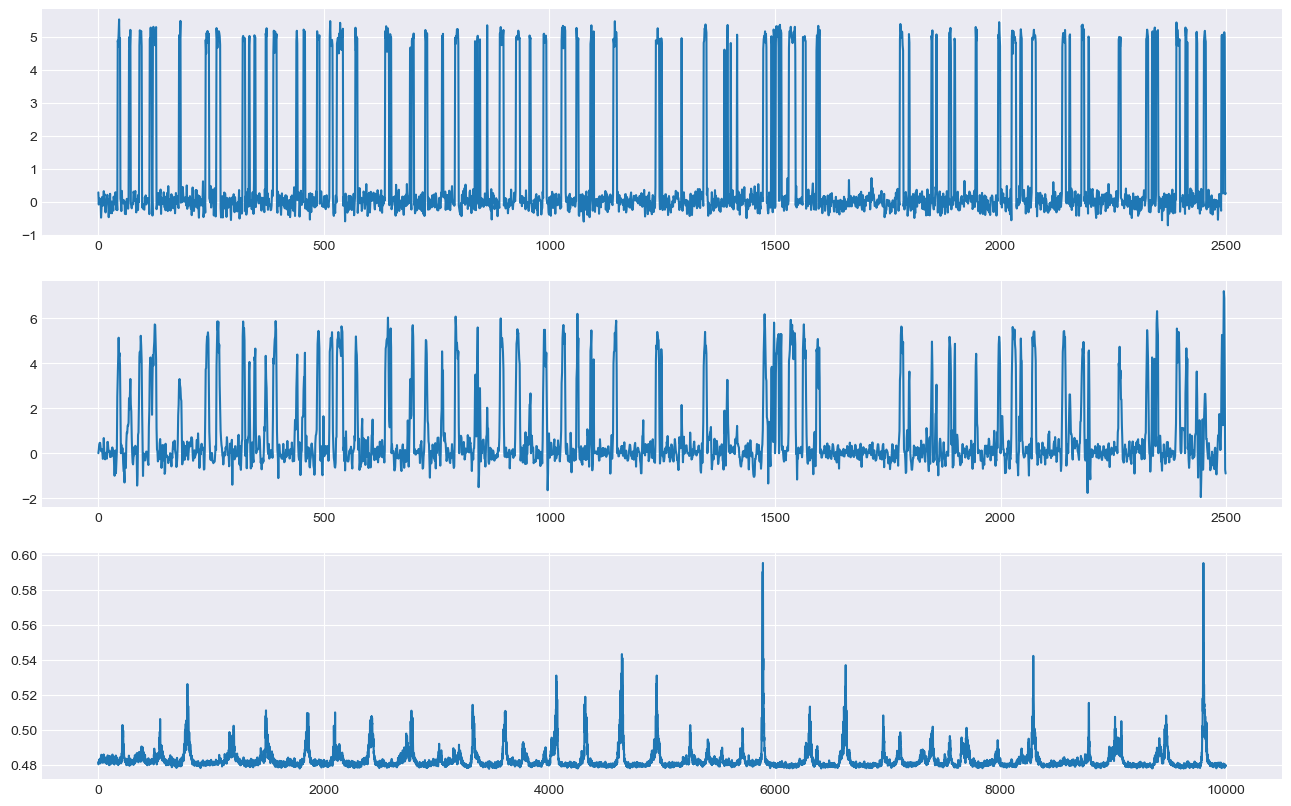

In [54]:
fig, axs = plt.subplots(nrows=3, figsize=(16, 10))
axs[0].plot(x.numpy().reshape(-1))
axs[1].plot(model(x.numpy()).numpy().reshape(-1))
axs[2].plot(history.history["loss"])
plt.show()

In [14]:
model.save_weights('modeli.h5')

In [15]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=DtwLoss(batch_size=batch_size))

In [ ]:
class DtwLossKG(tf.keras.losses.Loss):
    def __init__(self, batch_size: int = 32):
        super(DtwLossKG, self).__init__()
        self.batch_size = batch_size
        self.r = tf.constant(20, dtype=tf.int32)
        
    def call(self, y_true, y_predict):
        LB_sum = tf.constant(0.0, dtype=tf.float32)  # Initialize the loss sum
        for batch in range(self.batch_size):
            #tf.print("y shape",y_predict.shape)
            #tf.print(y_predict)
            #tf.print("x shape",y_true.shape)
            #tf.print("batch", batch)
            s1=y_true[batch,:]
            s2=y_predict[batch,:]
            for index in range(len(s1)):
                ind=tf.cast(index,dtype=tf.int32)
                i=tf.cast(s1[ind],dtype=tf.float32)
                #tf.print("s2=",s2)
                lower_bound = tf.reduce_min(s2[(ind - self.r if ind - self.r >= 0 else 0):\
                                               (ind + self.r)])
                upper_bound = tf.reduce_max(s2[(ind - self.r if ind - self.r >= 0 else 0):\
                                               (ind + self.r)])
                #tf.print("upper, lower",upper_bound, lower_bound)
                if i > upper_bound:
                    LB_sum += tf.abs(i - upper_bound)
                elif i < lower_bound:
                    LB_sum += tf.abs(i - lower_bound)

                #LB_sum += LB_sum       
        return LB_sum
    
lossKG = DtwLossKG(batch_size=1)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=lossKG)
print(y.numpy().shape)
history2=model.fit(x.numpy(), y.numpy(), epochs=100,batch_size=1)

(50, 50)
Epoch 1/100
50/50 [==============================] - 30s 99ms/step - loss: 17.6942
Epoch 2/100
50/50 [==============================] - 5s 98ms/step - loss: 12.3365
Epoch 3/100
50/50 [==============================] - 5s 98ms/step - loss: 7.4655
Epoch 4/100
50/50 [==============================] - 5s 99ms/step - loss: 3.9948
Epoch 5/100
50/50 [==============================] - 5s 98ms/step - loss: 2.6350
Epoch 6/100
50/50 [==============================] - 5s 98ms/step - loss: 1.9759
Epoch 7/100
50/50 [==============================] - 5s 98ms/step - loss: 1.5710
Epoch 8/100
50/50 [==============================] - 5s 98ms/step - loss: 1.2374
Epoch 9/100
50/50 [==============================] - 5s 99ms/step - loss: 1.0546
Epoch 10/100
50/50 [==============================] - 5s 99ms/step - loss: 0.9055
Epoch 11/100
50/50 [==============================] - 5s 98ms/step - loss: 0.7817
Epoch 12/100
50/50 [==============================] - 5s 99ms/step - loss: 0.6505
Epoch 13/100


In [ ]:
fig, axs = plt.subplots(nrows=3, figsize=(16, 10))
axs[0].plot(x.numpy().reshape(-1))
axs[1].plot(model(x.numpy()).numpy().reshape(-1))
axs[2].plot(history2.history["loss"])
plt.show()

In [350]:
x.numpy().shape
lossKG = DtwLossKG(batch_size=1)
lossKG(x,y)

y shape TensorShape([50, 50])
[[0 0 0 ... 5 5 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 5 0 0]
 [0 0 0 ... 0 0 0]
 [0 5 5 ... 5 0 0]]
x shape TensorShape([50, 50])
batch 0


InvalidArgumentError: cannot compute Greater as input #1(zero-based) was expected to be a float tensor but is a int32 tensor [Op:Greater]

In [321]:
#model.load_weights('model.h5')
lossKG = DtwLossKG(batch_size=1)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=lossKG)

              
              

In [322]:
history2=model.fit(x.numpy(), x.numpy(), epochs=1)

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
1/2 [==============>...............] - ETA: 25s - loss: 0.0000e+00[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
2/2 [==============================] - 26s 125ms/step - loss: 0.0000e+00


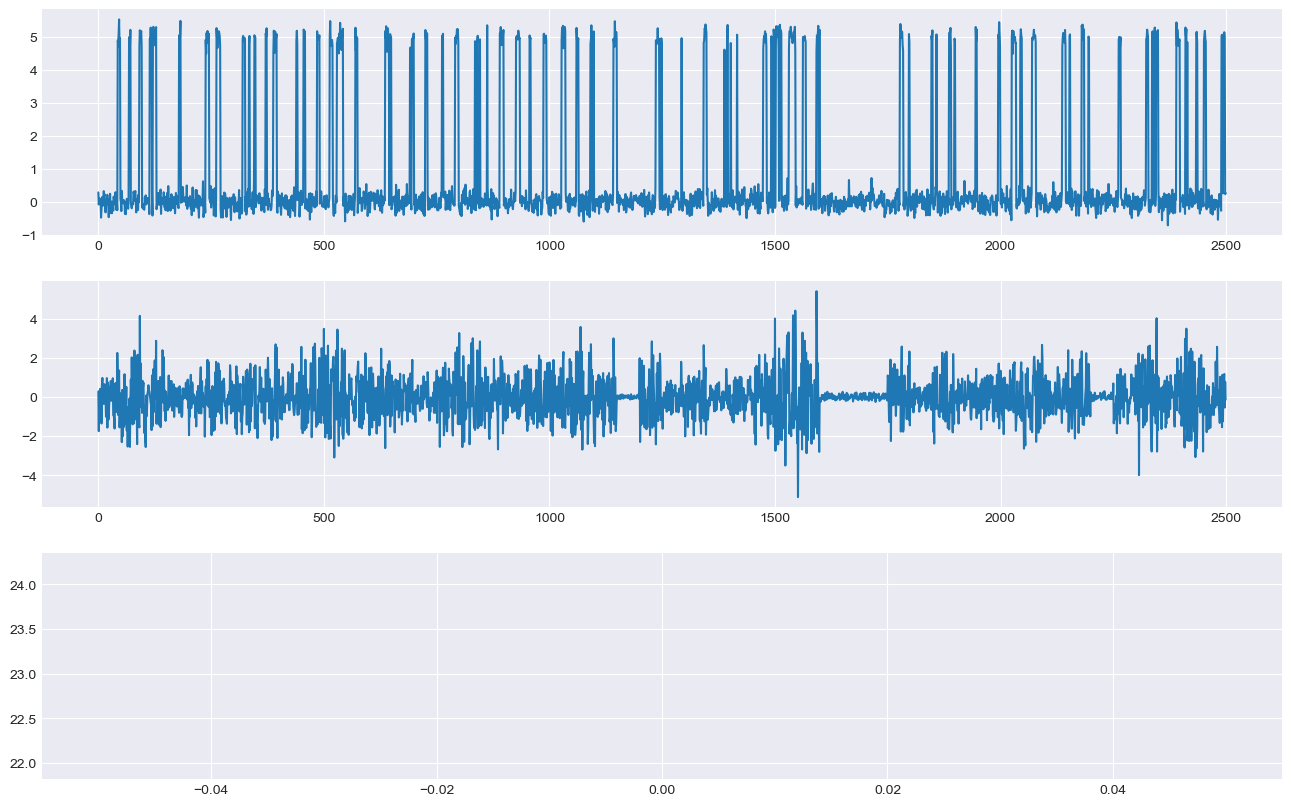

In [351]:
fig, axs = plt.subplots(nrows=3, figsize=(16, 10))
axs[0].plot(x.numpy().reshape(-1))
axs[1].plot(model(x.numpy()).numpy().reshape(-1))
axs[2].plot(history2.history["loss"])
plt.show()

OK doesn't work at all, I presume because we have only one file. I thought it would just overfit it? Given enough itterations.  Try again with 1000x the itterations...